In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import iqr
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

# Set display options for better readability
pd.set_option('display.max_columns', None)

Dataset Shape: (2935849, 10)

Data Types:
 date                   object
date_block_num          int64
shop_id                 int64
item_id                 int64
item_price            float64
item_cnt_day          float64
item_name              object
item_category_id        int64
item_category_name     object
shop_name              object
dtype: object

First 5 Rows:
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

                                  item_name  item_category_id  \
0                    ANNOUNCEMENT 2012 (BD)                37   
1  DEEP PURPLE  The House Of Blue 

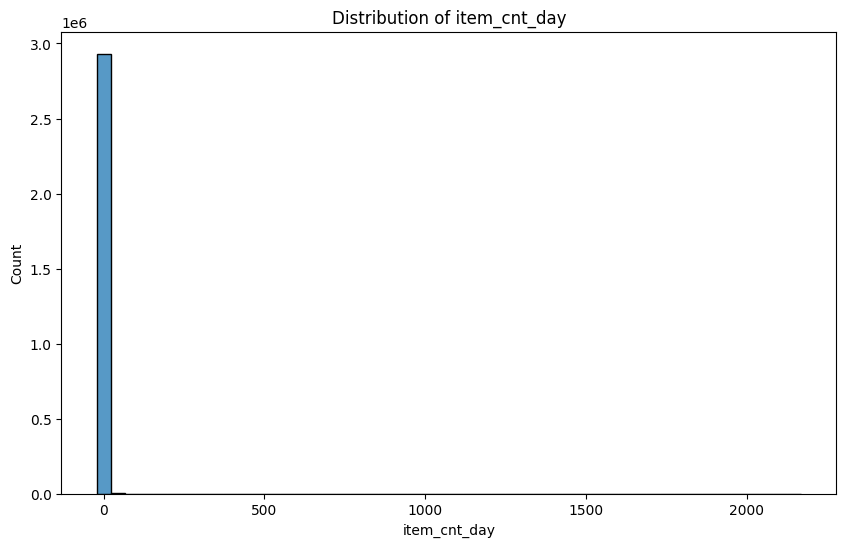


Number of Unique Shops: 60


In [2]:

# Load the merged dataset
data_path = '/Users/mohammednihal/XAI-2/Predict Future Sales/merged_data.csv'
df = pd.read_csv(data_path)

# Display basic information
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 Rows:\n", df.head())

# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())

# Descriptive statistics for item_cnt_day
print("\nItem Count Descriptive Stats:\n", df['item_cnt_day'].describe())

# Visualize item_cnt_day distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['item_cnt_day'], bins=50)
plt.title('Distribution of item_cnt_day')
plt.show()

# Check number of unique shops
print("\nNumber of Unique Shops:", df['shop_id'].nunique())

In [3]:
# Cell 3: Date Conversion and Time-Based Features
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

# Extract time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek

# Verify date range
print("Date Range:", df['date'].min(), "to", df['date'].max())

Date Range: 2013-01-01 00:00:00 to 2015-10-31 00:00:00


In [4]:
# Create returns column (negative values from item_cnt_day converted to positive)
df['returns'] = df['item_cnt_day'].where(df['item_cnt_day'] < 0, 0).abs()

negative_count = (df['item_cnt_day'] < 0).sum()
print(f"Number of Negative item_cnt_day Values (Returns): {negative_count}")

# Add the returns back to inventory (convert returns to positive additions)
df['item_cnt_day'] = df['item_cnt_day'] + df['returns']

# Now set negative values to 0 (though there shouldn't be any after the previous operation)
df.loc[df['item_cnt_day'] < 0, 'item_cnt_day'] = 0

print("Negative Values in item_cnt_day After Handling:", (df['item_cnt_day'] < 0).sum())
print("Sum of Returns (Positive Values in Returns Column):", df['returns'].sum())


Number of Negative item_cnt_day Values (Returns): 7356
Negative Values in item_cnt_day After Handling: 0
Sum of Returns (Positive Values in Returns Column): 7541.0


In [5]:
# Cell 5: Shop ID Handling
# Identify shops to retain (paper uses 54 shops, initial data has 60)
# Assuming we filter based on sales activity (top 54 shops by sales volume)
shop_sales = df.groupby('shop_id')['item_cnt_day'].sum().sort_values(ascending=False)
shops_to_keep = shop_sales.head(54).index.tolist()
print(f"Shops to Keep (54): {shops_to_keep}")

# Filter dataset to include only the 54 shops
df_processed = df[df['shop_id'].isin(shops_to_keep)]
print("Dataset Shape After Shop Filtering:", df.shape)
print("Number of Unique Shops After Filtering:", df['shop_id'].nunique())

Shops to Keep (54): [31, 25, 54, 28, 42, 57, 27, 6, 58, 46, 56, 50, 12, 19, 15, 35, 21, 26, 47, 7, 18, 24, 55, 53, 16, 30, 22, 29, 38, 43, 52, 41, 59, 51, 14, 37, 44, 4, 5, 45, 2, 3, 17, 48, 10, 13, 49, 39, 9, 0, 32, 23, 34, 1]
Dataset Shape After Shop Filtering: (2935849, 14)
Number of Unique Shops After Filtering: 60


In [6]:
print(df_processed.head())


        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-05               0       25     2552      899.00           0.0   
3 2013-01-06               0       25     2554     1709.05           1.0   
4 2013-01-15               0       25     2555     1099.00           1.0   

                                  item_name  item_category_id  \
0                    ANNOUNCEMENT 2012 (BD)                37   
1  DEEP PURPLE  The House Of Blue Light  LP                58   
2  DEEP PURPLE  The House Of Blue Light  LP                58   
3  DEEP PURPLE  Who Do You Think We Are  LP                58   
4            DEEP PURPE 30 Very Best Of 2CD                56   

                 item_category_name            shop_name  year  month  \
0                 Cinema - Blue-Ray  Jaroslavl TC Altair  2013      1   
1     


Item Count Descriptive Stats Before Outlier Treatment:
 count    2.920556e+06
mean     1.244594e+00
std      2.620760e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


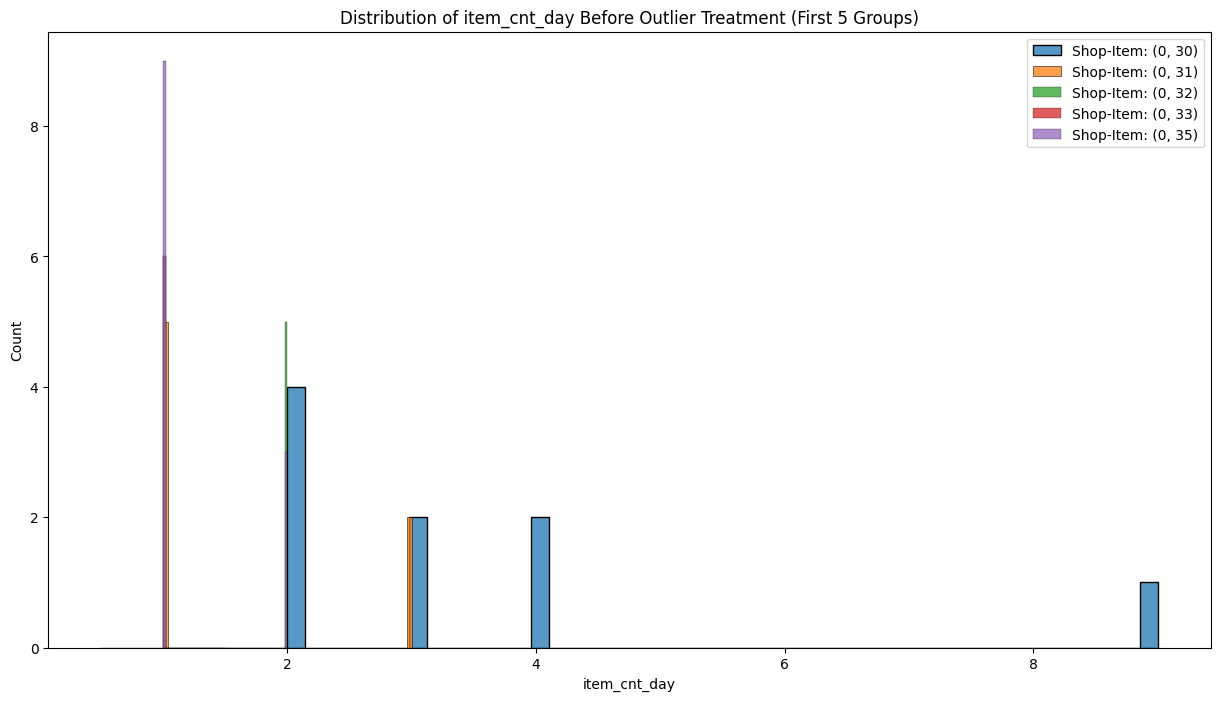

Processing shop-item groups: 100%|██████████| 418123/418123 [05:18<00:00, 1312.28it/s]


Total Number of Outliers Capped (5σ Rolling): 163


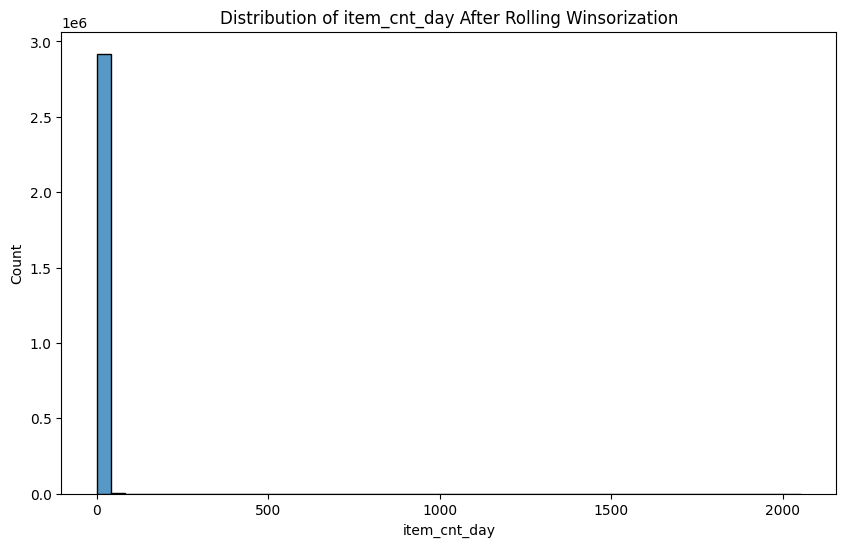

Dataset Shape After Outlier Treatment: (2920556, 14)

Item Count Descriptive Stats After Outlier Treatment:
 count    2.920556e+06
mean     1.244444e+00
std      2.580295e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.053646e+03
Name: item_cnt_day, dtype: float64


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day_of_week,returns
173349,2013-02-15,1,0,30,265.0,2.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,4,0.0
173348,2013-02-16,1,0,30,265.0,9.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,5,0.0
173347,2013-02-17,1,0,30,265.0,4.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,6,0.0
173346,2013-02-18,1,0,30,265.0,4.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,0,0.0
173345,2013-02-20,1,0,30,265.0,2.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,2,0.0


In [7]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the merged dataset
df = df_processed


# Define function for rolling statistics-based Winsorization
def winsorize_outliers_rolling(df, group_cols=['shop_id', 'item_id'], target_col='item_cnt_day'):
    # Sort by date to ensure correct rolling window
    df = df.sort_values(['shop_id', 'item_id', 'date']).copy()
    
    # Print stats before treatment
    print("\nItem Count Descriptive Stats Before Outlier Treatment:\n", df[target_col].describe())
    
    # Visualize distribution before outlier treatment for a few groups
    plt.figure(figsize=(15, 8))
    plt.title('Distribution of item_cnt_day Before Outlier Treatment (First 5 Groups)')
    
    # Get a list of the first 5 groups
    grouped_data = df.groupby(group_cols)
    group_names = list(grouped_data.groups.keys())[:5] # Get the first 5 group names
    
    for group_name in group_names:
        group = grouped_data.get_group(group_name)
        sns.histplot(group[target_col], bins=50, label=f'Shop-Item: {group_name}')
    plt.legend()
    plt.show()
    
    # Initialize output column
    df['item_cnt_day_winsorized'] = df[target_col]
    
    # Initialize counter for outliers
    total_outliers = 0
    
    # Process each group
    for _, group in tqdm(df.groupby(group_cols), desc="Processing shop-item groups"):
        # Get indices for this group
        idx = group.index
        
        # Calculate rolling mean and std with a 30-day window
        rolling_mean = group[target_col].rolling(window=30, min_periods=1).mean()
        rolling_std = group[target_col].rolling(window=30, min_periods=1).std().fillna(0)
        # Use 5σ threshold and ensure minimum cap
        upper_bound = np.maximum(rolling_mean + 5 * rolling_std, rolling_mean + 10)
        
        # Count outliers
        outliers = (df.loc[idx, target_col] > upper_bound).sum()
        total_outliers += outliers
        
        # Apply Winsorization
        df.loc[idx, 'item_cnt_day_winsorized'] = np.where(
            df.loc[idx, target_col] > upper_bound,
            upper_bound,
            df.loc[idx, target_col]
        )
    
    print(f"Total Number of Outliers Capped (5σ Rolling): {total_outliers}")
    
    return df, total_outliers

# Apply Winsorization and capture outlier count
df, outlier_count = winsorize_outliers_rolling(df)

# Replace original item_cnt_day with winsorized values
df['item_cnt_day'] = df['item_cnt_day_winsorized']
df = df.drop(columns=['item_cnt_day_winsorized'])

# Visualize distribution after outlier treatment
plt.figure(figsize=(10, 6))
sns.histplot(df['item_cnt_day'], bins=50)
plt.title('Distribution of item_cnt_day After Rolling Winsorization')
plt.show()

# Print dataset shape and stats
print("Dataset Shape After Outlier Treatment:", df.shape)
print("\nItem Count Descriptive Stats After Outlier Treatment:\n", df['item_cnt_day'].describe())
df.head()

In [8]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,year,month,day_of_week,returns
173349,2013-02-15,1,0,30,265.0,2.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,4,0.0
173348,2013-02-16,1,0,30,265.0,9.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,5,0.0
173347,2013-02-17,1,0,30,265.0,4.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,6,0.0
173346,2013-02-18,1,0,30,265.0,4.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,0,0.0
173345,2013-02-20,1,0,30,265.0,2.0,007: SKIPHALL COORDINATES,40,Cinema - DVD,"Jakutsk Orjonikidze, 56 Fran",2013,2,2,0.0


In [16]:
import pandas as pd
import numpy as np

# Aggregate daily sales and returns to monthly level
df_monthly = df.groupby(['date_block_num', 'shop_id', 'item_id'])[['item_cnt_day', 'returns']].sum().reset_index()
df_monthly = df_monthly.rename(columns={'item_cnt_day': 'item_cnt_month'})

# Merge back categorical features (item_category_id)
df_items = df[['item_id', 'item_category_id']].drop_duplicates()
df_monthly = df_monthly.merge(df_items, on='item_id', how='left')

# Define recent months to keep (try 15 months)
max_month = df['date_block_num'].max()
num_months = 15
recent_months = list(range(max_month - num_months + 1, max_month + 1))

# Get active shop-item pairs with sales in recent months only
df_recent = df_monthly[df_monthly['date_block_num'].isin(recent_months)]
active_pairs = df_recent.groupby(['shop_id', 'item_id'])['item_cnt_month'].sum()
active_pairs = active_pairs[active_pairs > 0].index.to_frame(index=False)

# Create DataFrame for recent months
df_months = pd.DataFrame({'date_block_num': recent_months})

# Cross join active pairs with recent months
active_pairs['key'] = 1
df_months['key'] = 1
full_grid = active_pairs.merge(df_months, on='key').drop('key', axis=1)

# Merge with monthly aggregated data filtered to recent months
df_monthly_full = full_grid.merge(
    df_recent,
    on=['shop_id', 'item_id', 'date_block_num'],
    how='left'
)

# Impute missing values
df_monthly_full['item_cnt_month'] = df_monthly_full['item_cnt_month'].fillna(0)
df_monthly_full['returns'] = df_monthly_full['returns'].fillna(0)
df_monthly_full['item_category_id'] = df_monthly_full['item_category_id'].fillna(-1)

# Do NOT filter out zero sales/returns months to keep dataset larger

# Check final size
print("Filtered Data Shape:", df_monthly_full.shape)
print("Unique Shop-Item Pairs:", df_monthly_full.groupby(['shop_id', 'item_id']).ngroups)


Filtered Data Shape: (2908335, 6)
Unique Shop-Item Pairs: 193889


In [17]:
# Assuming df_monthly_full is your final DataFrame from previous step

# Create lag features for item_cnt_month (1, 2, 3 months)
for lag in [1, 2, 3]:
    df_monthly_full[f'lag_{lag}'] = df_monthly_full.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)

# Fill NaN values in lag features with 0 (no sales in previous months)
df_monthly_full.fillna({f'lag_{lag}': 0 for lag in [1, 2, 3]}, inplace=True)

# Additional lag features: mean sales per shop and per category (lag 1)
df_monthly_full['shop_mean_lag_1'] = df_monthly_full.groupby('shop_id')['item_cnt_month'].shift(1).fillna(0)
df_monthly_full['category_mean_lag_1'] = df_monthly_full.groupby('item_category_id')['item_cnt_month'].shift(1).fillna(0)

print("\nColumns After Lag Features:\n", df_monthly_full.columns)



Columns After Lag Features:
 Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'returns',
       'item_category_id', 'lag_1', 'lag_2', 'lag_3', 'shop_mean_lag_1',
       'category_mean_lag_1'],
      dtype='object')


In [18]:
# Use target encoding for categorical variables (shop_id, item_id, item_category_id)
for col in ['shop_id', 'item_id', 'item_category_id']:
    mean_target = df_monthly_full.groupby(col)['item_cnt_month'].mean()
    df_monthly_full[f'{col}_encoded'] = df_monthly_full[col].map(mean_target)

# Drop original categorical columns
df_monthly_full = df_monthly_full.drop(['shop_id', 'item_id', 'item_category_id'], axis=1)

print("\nColumns After Encoding:\n", df_monthly_full.columns)



Columns After Encoding:
 Index(['date_block_num', 'item_cnt_month', 'returns', 'lag_1', 'lag_2',
       'lag_3', 'shop_mean_lag_1', 'category_mean_lag_1', 'shop_id_encoded',
       'item_id_encoded', 'item_category_id_encoded'],
      dtype='object')


In [21]:
def print_date_block_stats(df, split_name):
    counts = df['date_block_num'].value_counts().sort_index()
    print(f"\n{split_name} Set - Date Block Stats:")
    print(f"Total samples: {len(df)}")
    print(f"Unique months: {counts.shape[0]}")
    print(f"Month range: {counts.index.min()} to {counts.index.max()}")
    print(f"Samples per month stats:")
    print(f"  Min: {counts.min()}")
    print(f"  Max: {counts.max()}")
    print(f"  Mean: {counts.mean():.2f}")
    print(f"  Median: {counts.median()}")
    print(f"  Std Dev: {counts.std():.2f}")

    print("\nSamples per month:")
    print(counts)

# Print stats for each split
print_date_block_stats(train_data, "Train")
print_date_block_stats(valid_data, "Validation")
print_date_block_stats(test_data, "Test")



Train Set - Date Block Stats:
Total samples: 969445
Unique months: 5
Month range: 19 to 23
Samples per month stats:
  Min: 193889
  Max: 193889
  Mean: 193889.00
  Median: 193889.0
  Std Dev: 0.00

Samples per month:
date_block_num
19    193889
20    193889
21    193889
22    193889
23    193889
Name: count, dtype: int64

Validation Set - Date Block Stats:
Total samples: 1163334
Unique months: 6
Month range: 24 to 29
Samples per month stats:
  Min: 193889
  Max: 193889
  Mean: 193889.00
  Median: 193889.0
  Std Dev: 0.00

Samples per month:
date_block_num
24    193889
25    193889
26    193889
27    193889
28    193889
29    193889
Name: count, dtype: int64

Test Set - Date Block Stats:
Total samples: 775556
Unique months: 4
Month range: 30 to 33
Samples per month stats:
  Min: 193889
  Max: 193889
  Mean: 193889.00
  Median: 193889.0
  Std Dev: 0.00

Samples per month:
date_block_num
30    193889
31    193889
32    193889
33    193889
Name: count, dtype: int64


In [25]:
import pandas as pd

# 1. Calculate month counts and cumulative sums
month_counts = df_monthly_full['date_block_num'].value_counts().sort_index()
cum_counts = month_counts.cumsum()
total_samples = month_counts.sum()

# 2. Find split months for ~70%, ~90%
train_cutoff = total_samples * 0.7
valid_cutoff = total_samples * 0.9

train_end_month = cum_counts[cum_counts <= train_cutoff].index.max()
valid_end_month = cum_counts[cum_counts <= valid_cutoff].index.max()

print(f"Train ends at month: {train_end_month}")
print(f"Validation ends at month: {valid_end_month}")

# 3. Define month ranges for splits
train_months = list(range(0, train_end_month + 1))
valid_months = list(range(train_end_month + 1, valid_end_month + 1))
test_months = list(range(valid_end_month + 1, df_monthly_full['date_block_num'].max() + 1))

# 4. Create splits
train_data = df_monthly_full[df_monthly_full['date_block_num'].isin(train_months)].copy()
valid_data = df_monthly_full[df_monthly_full['date_block_num'].isin(valid_months)].copy()
test_data = df_monthly_full[df_monthly_full['date_block_num'].isin(test_months)].copy()

# 5. Separate features (X) and target (y)
target_col = 'item_cnt_month'

X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]

X_valid = valid_data.drop(columns=[target_col])
y_valid = valid_data[target_col]

X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

print("Train Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_valid.shape, y_valid.shape)
print("Test Data Shape:", X_test.shape, y_test.shape)

# 6. Save to Parquet files
X_train.to_parquet('X_train.parquet', index=False)
y_train.to_frame().to_parquet('y_train.parquet', index=False)

X_valid.to_parquet('X_valid.parquet', index=False)
y_valid.to_frame().to_parquet('y_valid.parquet', index=False)

X_test.to_parquet('X_test.parquet', index=False)
y_test.to_frame().to_parquet('y_test.parquet', index=False)

print("Data saved to Parquet files successfully.")


Train ends at month: 28
Validation ends at month: 31
Train Data Shape: (1938890, 10) (1938890,)
Validation Data Shape: (581667, 10) (581667,)
Test Data Shape: (387778, 10) (387778,)
Data saved to Parquet files successfully.



Preprocessing Summary:
Initial Shape: (2920556, 14)
Initial Unique Shops: 54
Initial Unique Items: 21768
Initial Unique Categories: 84
Negative Values Handled: 7356
Outliers Capped (IQR): 163
Final Train Shape: (1938890, 11)
Final Validation Shape: (581667, 11)
Final Test Shape: (387778, 11)
Train Zero Sales Rows: 1516616
Validation Zero Sales Rows: 482785
Test Zero Sales Rows: 327250
Train Target Mean: 0.5223767399031611
Validation Target Mean: 0.333069746895309
Test Target Mean: 0.3638629611494135
Features Used: ['date_block_num', 'item_cnt_month', 'returns', 'lag_1', 'lag_2', 'lag_3', 'shop_mean_lag_1', 'category_mean_lag_1', 'shop_id_encoded', 'item_id_encoded', 'item_category_id_encoded']


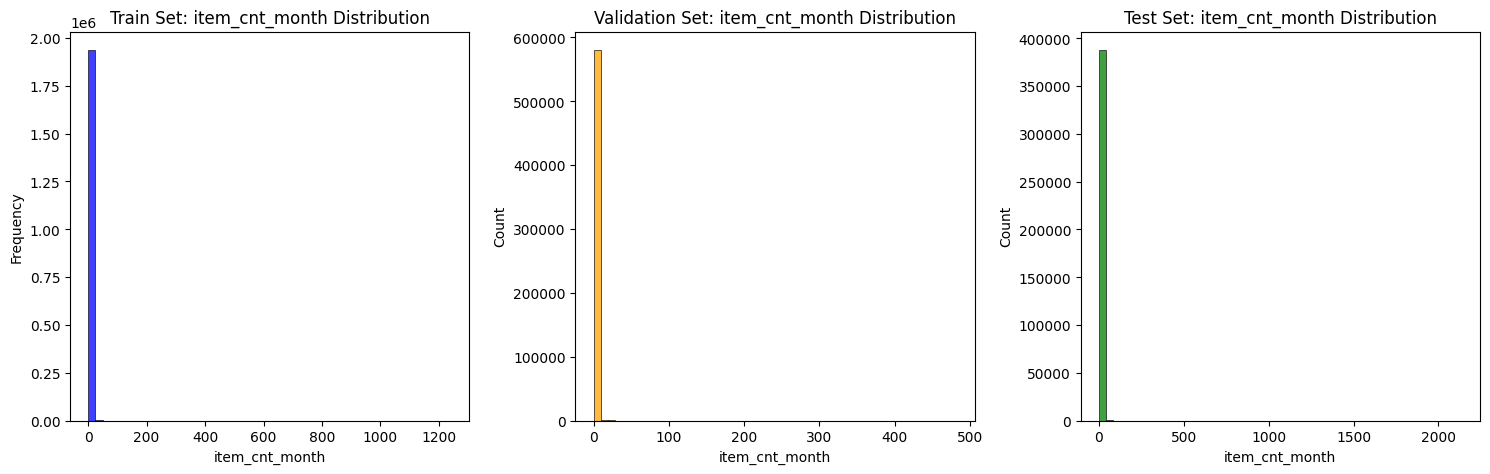

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Save preprocessed datasets (assuming train_data, valid_data, test_data defined)
train_data.to_csv('train_preprocessed.csv', index=False)
valid_data.to_csv('valid_preprocessed.csv', index=False)
test_data.to_csv('test_preprocessed.csv', index=False)

# Helper function to get dataset stats
def dataset_stats(df, name):
    stats = {}
    stats['Shape'] = df.shape
    stats['Unique Shops'] = df['shop_id'].nunique() if 'shop_id' in df.columns else 'N/A'
    stats['Unique Items'] = df['item_id'].nunique() if 'item_id' in df.columns else 'N/A'
    stats['Unique Categories'] = df['item_category_id'].nunique() if 'item_category_id' in df.columns else 'N/A'
    stats['Missing Values'] = df.isnull().sum().sum()
    stats['Zero Sales Rows'] = (df['item_cnt_month'] == 0).sum()
    stats['Target Mean'] = df['item_cnt_month'].mean()
    stats['Target Median'] = df['item_cnt_month'].median()
    stats['Target Max'] = df['item_cnt_month'].max()
    stats['Target Std'] = df['item_cnt_month'].std()
    return stats

# Collect stats for initial and final datasets
initial_stats = {
    'Initial Shape': df.shape,
    'Initial Unique Shops': df['shop_id'].nunique(),
    'Initial Unique Items': df['item_id'].nunique(),
    'Initial Unique Categories': df['item_category_id'].nunique(),
    'Negative Values Handled': negative_count,
    'Outliers Capped (IQR)': outlier_count,
}

train_stats = dataset_stats(train_data, 'Train')
valid_stats = dataset_stats(valid_data, 'Validation')
test_stats = dataset_stats(test_data, 'Test')

# Combine all stats into one summary dict
summary = {
    **initial_stats,
    'Final Train Shape': train_stats['Shape'],
    'Final Validation Shape': valid_stats['Shape'],
    'Final Test Shape': test_stats['Shape'],
    'Train Zero Sales Rows': train_stats['Zero Sales Rows'],
    'Validation Zero Sales Rows': valid_stats['Zero Sales Rows'],
    'Test Zero Sales Rows': test_stats['Zero Sales Rows'],
    'Train Target Mean': train_stats['Target Mean'],
    'Validation Target Mean': valid_stats['Target Mean'],
    'Test Target Mean': test_stats['Target Mean'],
    'Features Used': list(train_data.columns),
}

# Print detailed summary
print("\nPreprocessing Summary:")
for key, value in summary.items():
    print(f"{key}: {value}")

# Visualize target distribution in train, validation, and test sets
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_data['item_cnt_month'], bins=50, color='blue', kde=False)
plt.title('Train Set: item_cnt_month Distribution')
plt.xlabel('item_cnt_month')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(valid_data['item_cnt_month'], bins=50, color='orange', kde=False)
plt.title('Validation Set: item_cnt_month Distribution')
plt.xlabel('item_cnt_month')

plt.subplot(1, 3, 3)
sns.histplot(test_data['item_cnt_month'], bins=50, color='green', kde=False)
plt.title('Test Set: item_cnt_month Distribution')
plt.xlabel('item_cnt_month')

plt.tight_layout()
plt.show()


In [27]:
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import polars as pl
from tqdm import tqdm
from pathlib import Path
import logging

# Minimal logging for RunPod
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# GPU Configuration for RunPod
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision('high')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

class SalesDataset(Dataset):
    def __init__(self, X_file, y_file, sequence_length=12, num_shops=54, num_items=21768, num_categories=84):
        logger.info(f"Loading dataset from {X_file}")
        start = time.time()
        
        # Load Parquet files
        self.X = pl.read_parquet(X_file)
        self.y = pl.read_parquet(y_file).select(['item_cnt_month']).to_numpy().flatten().astype(np.float32)
        logger.info(f"Loaded Parquet files in {time.time() - start:.2f}s")
        
        if len(self.X) != len(self.y):
            raise ValueError(f"Mismatch between X ({len(self.X)}) and y ({len(self.y)}) rows")
        
        self.sequence_length = sequence_length
        self.num_shops = num_shops
        self.num_items = num_items
        self.num_categories = num_categories
        
        # Define numerical and categorical columns
        self.numerical_cols = [
            'date_block_num', 'returns', 'lag_1', 'lag_2', 'lag_3',
            'shop_mean_lag_1', 'category_mean_lag_1'
        ]
        self.categorical_cols = ['shop_id_encoded', 'item_id_encoded', 'item_category_id_encoded']
        
        # Validate and normalize numerical data
        numerical_data = self.X.select(self.numerical_cols).to_numpy()
        if np.isnan(numerical_data).any() or np.isnan(self.y).any():
            raise ValueError("NaN values in X or y")
        if np.isinf(numerical_data).any() or np.isinf(self.y).any():
            raise ValueError("Infinite values in X or y")
        
        # Normalize numerical data (using robust scaling as per preprocessing)
        numerical_data = np.clip(numerical_data, -1e5, 1e5)
        mean = numerical_data.mean(axis=0, keepdims=True)
        std = numerical_data.std(axis=0, keepdims=True) + 1e-6
        numerical_data = (numerical_data - mean) / std
        
        # Normalize target (using provided mean and std for train split)
        self.y = np.clip(self.y, -1e5, 1e5)
        self.y_mean = 0.5224  # Train target mean
        self.y_std = self.y.std() + 1e-6
        self.y = (self.y - self.y_mean) / self.y_std
        
        # Clip categorical indices
        self.X = self.X.with_columns([
            pl.col('shop_id_encoded').clip(upper_bound=num_shops - 1),
            pl.col('item_id_encoded').clip(upper_bound=num_items - 1),
            pl.col('item_category_id_encoded').clip(upper_bound=num_categories - 1)
        ])
        
        # Preload data for GPU efficiency
        self.numerical = numerical_data.astype(np.float32)
        self.shop_ids = self.X['shop_id_encoded'].to_numpy().astype(np.int64)
        self.item_ids = self.X['item_id_encoded'].to_numpy().astype(np.int64)
        self.category_ids = self.X['item_category_id_encoded'].to_numpy().astype(np.int64)
        self.date_block_num = self.X['date_block_num'].to_numpy().astype(np.int32)
        
    def __len__(self):
        return len(self.X) - self.sequence_length + 1
    
    def __getitem__(self, idx):
        try:
            start_idx = idx
            end_idx = idx + self.sequence_length
            if end_idx > len(self.X):
                raise IndexError("Index out of range")
            
            numerical = torch.tensor(self.numerical[start_idx:end_idx], dtype=torch.float32)
            shop_ids = torch.tensor(self.shop_ids[start_idx:end_idx], dtype=torch.int64)
            item_ids = torch.tensor(self.item_ids[start_idx:end_idx], dtype=torch.int64)
            category_ids = torch.tensor(self.category_ids[start_idx:end_idx], dtype=torch.int64)
            target = torch.tensor(self.y[end_idx - 1], dtype=torch.float32)
            identifiers = torch.tensor([
                int(self.shop_ids[end_idx - 1]), 
                int(self.item_ids[end_idx - 1]), 
                int(self.date_block_num[end_idx - 1])
            ], dtype=torch.int32)
            
            return {
                'numerical': numerical,
                'shop_ids': shop_ids,
                'item_ids': item_ids,
                'category_ids': category_ids,
                'target': target,
                'identifiers': identifiers
            }
        except Exception as e:
            logger.error(f"Error in __getitem__ at index {idx}: {str(e)}")
            raise

class HALSTM(nn.Module):
    def __init__(self, num_shops=54, num_items=21768, num_categories=84, embed_dim=16, numerical_dim=7,
                 hidden_dim=128, num_layers=2, num_heads=4, dropout=0.35, forecast_horizon=1):
        super(HALSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        # Embeddings for categorical variables
        self.shop_embed = nn.Embedding(num_shops, embed_dim)
        self.item_embed = nn.Embedding(num_items, embed_dim)
        self.category_embed = nn.Embedding(num_categories, embed_dim)
        nn.init.normal_(self.shop_embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.item_embed.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.category_embed.weight, mean=0.0, std=0.02)
        
        # Input dimension: numerical (7) + 3 * embed_dim
        self.input_dim = numerical_dim + embed_dim * 3
        self.lstm = nn.LSTM(self.input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.lstm_norm = nn.LayerNorm(hidden_dim)
        self.mha = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.mha_norm = nn.LayerNorm(hidden_dim)
        self.gate = nn.Linear(hidden_dim * 2, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc_shared = nn.Linear(hidden_dim, hidden_dim)
        self.fc_horizons = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(forecast_horizon)])
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # Positional encoding
        self.positional_encoding = self._create_positional_encoding(max_seq_len=100, d_model=hidden_dim)
        
        # Initialize linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def _create_positional_encoding(self, max_seq_len, d_model):
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.to(device)
    
    def forward(self, numerical, shop_ids, item_ids, category_ids):
        batch_size, seq_len, _ = numerical.size()
        shop_embed = self.shop_embed(shop_ids)
        item_embed = self.item_embed(item_ids)
        category_embed = self.category_embed(category_ids)
        
        # Concatenate inputs
        x = torch.cat([numerical, shop_embed, item_embed, category_embed], dim=-1).contiguous()
        x = self.dropout(x)
        
        # LSTM Encoder
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device).contiguous()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device).contiguous()
        lstm_out, _ = self.lstm(x, (h0, c0))
        lstm_out = self.lstm_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        
        # Add positional encoding
        lstm_out = lstm_out + self.positional_encoding[:seq_len, :].unsqueeze(0).to(lstm_out.device)
        
        # Multi-Head Self-Attention
        mha_out, mha_weights = self.mha(lstm_out, lstm_out, lstm_out)
        mha_out = self.mha_norm(mha_out)
        mha_out = self.dropout(mha_out)
        
        # Adaptive Fusion
        combined = torch.cat([lstm_out[:, -1, :], mha_out[:, -1, :]], dim=-1)
        gate = self.sigmoid(self.gate(combined))
        fused = gate * lstm_out[:, -1, :] + (1 - gate) * mha_out[:, -1, :]
        
        # Multi-Horizon Decoder
        shared = self.relu(self.fc_shared(fused))
        outputs = torch.cat([fc(shared).unsqueeze(1) for fc in self.fc_horizons], dim=1)
        outputs = outputs.squeeze(-1)
        
        return outputs, {'mha_weights': mha_weights, 'fused_output': fused, 'gate_weights': gate}

def collate_fn(batch):
    if not batch:
        logger.warning("Empty batch received")
        return {}
    
    numerical = torch.stack([item['numerical'] for item in batch])
    shop_ids = torch.stack([item['shop_ids'] for item in batch])
    item_ids = torch.stack([item['item_ids'] for item in batch])
    category_ids = torch.stack([item['category_ids'] for item in batch])
    target = torch.stack([item['target'] for item in batch])
    identifiers = torch.stack([item['identifiers'] for item in batch])
    
    return {
        'numerical': numerical.contiguous(),
        'shop_ids': shop_ids.contiguous(),
        'item_ids': item_ids.contiguous(),
        'category_ids': category_ids.contiguous(),
        'target': target.contiguous(),
        'identifiers': identifiers.contiguous()
    }

def train_model(model, train_loader, val_loader, num_epochs=50, lr=0.001, accum_steps=2):
    logger.info("Starting training")
    criterion = nn.MSELoss().to(device)
    scaler = torch.cuda.amp.GradScaler()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.05)
    l1_lambda = 1e-5
    att_lambda = 1e-5
    temp_lambda = 1e-5
    
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, epochs=num_epochs, steps_per_epoch=len(train_loader)//accum_steps, pct_start=0.1
    )
    
    best_val_loss = float('inf')
    output_dir = Path('/workspace/results')  # Adjust for RunPod
    output_dir.mkdir(exist_ok=True)
    
    patience = 3
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad(set_to_none=True)
        
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            try:
                numerical = batch['numerical'].to(device, non_blocking=True)
                shop_ids = batch['shop_ids'].to(device, non_blocking=True)
                item_ids = batch['item_ids'].to(device, non_blocking=True)
                category_ids = batch['category_ids'].to(device, non_blocking=True)
                target = batch['target'].to(device, non_blocking=True)
                
                with torch.cuda.amp.autocast():
                    output, attention_dict = model(numerical, shop_ids, item_ids, category_ids)
                    mse_loss = criterion(output[:, -1], target) / accum_steps
                    
                    att_loss = attention_dict['mha_weights'].abs().sum()
                    temp_loss = torch.zeros(1, device=device)
                    if output.shape[1] > 1:
                        temp_loss = (output[:, 1:] - output[:, :-1]).abs().sum()
                    l1_loss = sum(p.abs().sum() for p in model.parameters() if p.requires_grad)
                    
                    loss = mse_loss + l1_lambda * l1_loss + att_lambda * att_loss + temp_lambda * temp_loss
                
                scaler.scale(loss).backward()
                
                if (batch_idx + 1) % accum_steps == 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                    scaler.step(optimizer)
                    scheduler.step()
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                
                train_loss += mse_loss.item() * accum_steps
            except Exception as e:
                logger.error(f"Error in batch {batch_idx}: {str(e)}")
                continue
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                try:
                    numerical = batch['numerical'].to(device, non_blocking=True)
                    shop_ids = batch['shop_ids'].to(device, non_blocking=True)
                    item_ids = batch['item_ids'].to(device, non_blocking=True)
                    category_ids = batch['category_ids'].to(device, non_blocking=True)
                    target = batch['target'].to(device, non_blocking=True)
                    
                    with torch.cuda.amp.autocast():
                        output, _ = model(numerical, shop_ids, item_ids, category_ids)
                        loss = criterion(output[:, -1], target)
                    
                    val_loss += loss.item()
                except Exception as e:
                    logger.error(f"Error in validation: {str(e)}")
                    continue
        
        val_loss /= len(val_loader)
        logger.info(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), output_dir / 'best_ha_lstm.pth')
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            
        if early_stop_counter >= patience:
            logger.info(f"Early stopping after {epoch+1} epochs")
            break
        
        torch.cuda.empty_cache()
    
    logger.info(f"Training done. Best val loss: {best_val_loss:.6f}")
    model.load_state_dict(torch.load(output_dir / 'best_ha_lstm.pth'))
    return model

def predict(model, test_loader, dataset):
    logger.info("Predicting")
    model.eval()
    predictions = []
    identifiers = []
    fused_outputs = []  # To store adaptive fusion outputs
    gate_weights = []  # To store gate weights
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting"):
            try:
                numerical = batch['numerical'].to(device, non_blocking=True)
                shop_ids = batch['shop_ids'].to(device, non_blocking=True)
                item_ids = batch['item_ids'].to(device, non_blocking=True)
                category_ids = batch['category_ids'].to(device, non_blocking=True)
                
                with torch.cuda.amp.autocast():
                    output, attention_dict = model(numerical, shop_ids, item_ids, category_ids)
                    preds = output.cpu().numpy()
                    preds = preds * dataset.y_std + dataset.y_mean
                
                predictions.append(preds)
                identifiers.append(batch['identifiers'].cpu().numpy())
                fused_outputs.append(attention_dict['fused_output'].cpu().numpy())  # Save fused output
                gate_weights.append(attention_dict['gate_weights'].cpu().numpy())  # Save gate weights
                
            except Exception as e:
                logger.error(f"Error in prediction: {str(e)}")
                continue
            
            torch.cuda.empty_cache()
    
    if not predictions or not identifiers:
        logger.error("No predictions or identifiers collected")
        return pd.DataFrame()
        
    predictions = np.concatenate(predictions, axis=0)
    identifiers = np.concatenate(identifiers, axis=0)
    fused_outputs = np.concatenate(fused_outputs, axis=0)
    gate_weights = np.concatenate(gate_weights, axis=0)
    
    # Create DataFrame for predictions
    pred_df = pd.DataFrame({
        'shop_id': identifiers[:, 0],
        'item_id': identifiers[:, 1],
        'date_block_num': identifiers[:, 2]
    })
    for h in range(predictions.shape[1]):
        pred_df[f'forecast_h{h+1}'] = predictions[:, h]
    
    # Create DataFrame for fused outputs
    fused_df = pd.DataFrame(
        fused_outputs,
        columns=[f'fused_dim_{i}' for i in range(fused_outputs.shape[1])]
    )
    fused_df[['shop_id', 'item_id', 'date_block_num']] = identifiers
    
    # Create DataFrame for gate weights
    gate_df = pd.DataFrame(
        gate_weights,
        columns=[f'gate_dim_{i}' for i in range(gate_weights.shape[1])]
    )
    gate_df[['shop_id', 'item_id', 'date_block_num']] = identifiers
    
    # Save all outputs
    output_dir = Path('/workspace/results')
    output_dir.mkdir(exist_ok=True)
    
    pred_df.to_csv(output_dir / 'predictions.csv', index=False)
    logger.info(f"Predictions saved to {output_dir / 'predictions.csv'}")
    
    fused_df.to_csv(output_dir / 'fused_outputs.csv', index=False)
    logger.info(f"Fused outputs saved to {output_dir / 'fused_outputs.csv'}")
    
    gate_df.to_csv(output_dir / 'gate_weights.csv', index=False)
    logger.info(f"Gate weights saved to {output_dir / 'gate_weights.csv'}")
    
    return pred_df

def visualize_results(pred_df, true_df=None, output_dir='/workspace/results'):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)
    logger.info(f"Saving plots to {output_dir}")
    
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))
    
    if pred_df.empty:
        logger.error("Empty prediction dataframe")
        return None
    
    forecast_cols = [col for col in pred_df.columns if 'forecast' in col]
    if not forecast_cols:
        logger.error("No forecast columns found")
        return None
        
    for h in range(1, len(forecast_cols) + 1):
        sns.kdeplot(pred_df[f'forecast_h{h}'], label=f'Horizon {h}')
    
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Sales')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig(output_dir / 'prediction_distribution.png', dpi=300)
    plt.close()
    
    if true_df is not None and not true_df.empty:
        try:
            merged_df = pred_df.merge(true_df, on=['shop_id', 'item_id', 'date_block_num'], how='inner')
            if not merged_df.empty:
                merged_df['error'] = merged_df['forecast_h1'] - merged_df['item_cnt_month']
                
                plt.figure(figsize=(12, 8))
                sns.histplot(merged_df['error'], kde=True, bins=50)
                plt.title('Error Distribution')
                plt.xlabel('Prediction Error')
                plt.ylabel('Count')
                plt.tight_layout()
                plt.savefig(output_dir / 'error_distribution.png', dpi=300)
                plt.close()
                
                plt.figure(figsize=(12, 8))
                plt.scatter(merged_df['item_cnt_month'], merged_df['forecast_h1'], alpha=0.5)
                plt.plot([0, merged_df['item_cnt_month'].max()], 
                         [0, merged_df['item_cnt_month'].max()], 'r--')
                plt.title('Predicted vs Actual')
                plt.xlabel('Actual Sales')
                plt.ylabel('Predicted Sales')
                plt.tight_layout()
                plt.savefig(output_dir / 'predicted_vs_actual.png', dpi=300)
                plt.close()
                
                mae = merged_df['error'].abs().mean()
                rmse = (merged_df['error'] ** 2).mean() ** 0.5
                mape = (merged_df['error'].abs() / merged_df['item_cnt_month'].abs().replace(0, 1e-6)).mean() * 100
                logger.info(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
                
                return mae, rmse, mape
            else:
                logger.warning("Merged dataframe is empty")
        except Exception as e:
            logger.error(f"Error in visualization: {str(e)}")
    
    return None

def main():
    seed = 42
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
    # === Data Path Placeholders ===
    # Replace these paths with your actual Parquet file paths on RunPod
    data_dir = Path('/workspace/data')  # Adjust to your RunPod data directory
    train_X_path = data_dir / 'X_train_processed.parquet'
    train_y_path = data_dir / 'y_train_processed.parquet'
    val_X_path = data_dir / 'X_val_processed.parquet'
    val_y_path = data_dir / 'y_val_processed.parquet'
    test_X_path = data_dir / 'X_test_processed.parquet'
    test_y_path = data_dir / 'y_test_processed.parquet'
    
    batch_size = 8192  # Optimized for RunPod GPU (e.g., A100, adjust if needed)
    num_workers = 4    # Adjust based on RunPod CPU cores
    sequence_length = 12
    num_epochs = 50
    lr = 0.001
    accum_steps = 2
    
    logger.info("Loading datasets...")
    required_files = [train_X_path, train_y_path, val_X_path, val_y_path, test_X_path, test_y_path]
    missing_files = [f for f in required_files if not f.exists()]
    if missing_files:
        raise FileNotFoundError(f"Missing files: {', '.join(str(f) for f in missing_files)}")
    
    try:
        train_dataset = SalesDataset(
            train_X_path, train_y_path, sequence_length=sequence_length,
            num_shops=54, num_items=21768, num_categories=84
        )
        val_dataset = SalesDataset(
            val_X_path, val_y_path, sequence_length=sequence_length,
            num_shops=54, num_items=21768, num_categories=84
        )
        test_dataset = SalesDataset(
            test_X_path, test_y_path, sequence_length=sequence_length,
            num_shops=54, num_items=21768, num_categories=84
        )
        
        logger.info(f"Train dataset size: {len(train_dataset)}")
        logger.info(f"Val dataset size: {len(val_dataset)}")
        logger.info(f"Test dataset size: {len(test_dataset)}")
        
        # Verify dataset sizes
        expected_sizes = {'train': 1938890, 'val': 581667, 'test': 387778}
        for split, size, expected in [('train', len(train_dataset), expected_sizes['train']),
                                      ('val', len(val_dataset), expected_sizes['val']),
                                      ('test', len(test_dataset), expected_sizes['test'])]:
            if abs(size - expected) / expected > 0.1:
                logger.warning(f"{split.capitalize()} dataset size {size} deviates significantly from expected {expected}.")
        
    except Exception as e:
        logger.error(f"Error creating datasets: {str(e)}")
        raise
    
    try:
        train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
            pin_memory=True, collate_fn=collate_fn
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
            pin_memory=True, collate_fn=collate_fn
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
            pin_memory=True, collate_fn=collate_fn
        )
        
        logger.info("DataLoaders created successfully")
        
    except Exception as e:
        logger.error(f"Error creating DataLoaders: {str(e)}")
        raise
    
    try:
        model = HALSTM(
            num_shops=54, num_items=21768, num_categories=84,
            embed_dim=16, numerical_dim=7, hidden_dim=128,
            num_layers=2, num_heads=4, dropout=0.35, forecast_horizon=1
        ).to(device)
        
        logger.info(f"Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
        
        model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, lr=lr, accum_steps=accum_steps)
        
        predictions = predict(model, test_loader, test_dataset)
        
        true_df = pl.read_parquet(test_y_path).join(
            pl.read_parquet(test_X_path).select(['shop_id_encoded', 'item_id_encoded', 'date_block_num']),
            how='left'
        ).to_pandas().rename(columns={'shop_id_encoded': 'shop_id', 'item_id_encoded': 'item_id'})
        
        visualize_results(predictions, true_df)
        
    except Exception as e:
        logger.error(f"Error in main: {str(e)}")
        raise

if __name__ == '__main__':
    try:
        logger.info("Starting program")
        main()
        logger.info("Program completed successfully")
    except Exception as e:
        logger.error(f"Program failed: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        sys.exit(1)

2025-05-20 23:04:44 - INFO - Using device: cpu
2025-05-20 23:04:44 - INFO - Starting program
2025-05-20 23:04:44 - INFO - Loading datasets...
2025-05-20 23:04:44 - ERROR - Program failed: Missing files: /workspace/data/X_train_processed.parquet, /workspace/data/y_train_processed.parquet, /workspace/data/X_val_processed.parquet, /workspace/data/y_val_processed.parquet, /workspace/data/X_test_processed.parquet, /workspace/data/y_test_processed.parquet
2025-05-20 23:04:44 - ERROR - Traceback (most recent call last):
  File "/var/folders/h7/zh8nh5wx1fb6smgs5s2whtkr0000gn/T/ipykernel_15920/3436503763.py", line 583, in <module>
    main()
  File "/var/folders/h7/zh8nh5wx1fb6smgs5s2whtkr0000gn/T/ipykernel_15920/3436503763.py", line 504, in main
    raise FileNotFoundError(f"Missing files: {', '.join(str(f) for f in missing_files)}")
FileNotFoundError: Missing files: /workspace/data/X_train_processed.parquet, /workspace/data/y_train_processed.parquet, /workspace/data/X_val_processed.parquet, /

AttributeError: 'tuple' object has no attribute 'tb_frame'